## MLP: Initializations

In [ ]:
!pip install tensorflow==1.15

In [ ]:
## MLP: Initializations# https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/multi_layer_perceptron_mnist.html
# https://github.com/wagonhelm/NaNmnist/blob/master/NaNmnist.ipynb
# https://github.com/aymericdamien/TensorFlow-Examples/blob/master/notebooks/3_NeuralNetworks/neural_network.ipynb

from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

In [2]:
# %matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import time
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
def plt_dynamic(x, y, y_1, ax, ticks,title, colors=['b']):
    ax.plot(x, y, 'b', label="Train Loss")
    ax.plot(x, y_1, 'r', label="Test Loss")
    if len(x)==1:
        plt.legend()
        plt.title(title)
    plt.yticks(ticks)
    fig.canvas.draw()

In [3]:
# Network Parameters
n_hidden_1 = 512 # 1st layer number of neurons
n_hidden_2 = 128 # 2nd layer number of neurons
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)

In [4]:
# x isn't a specific value. It's a placeholder, a value that we'll input when we ask TensorFlow to run a computation.
# We want to be able to input any number of MNIST images, each flattened into a 784-dimensional vector. 
# We represent this as a 2-D tensor of floating-point numbers, with a shape X = [None, 784]. 
# (Here None means that a dimension can be of any length.)
x = tf.placeholder(tf.float32, [None, 784])
y_ = tf.placeholder(tf.float32, [None, 10])

# keep_prob: we will be using these placeholders when we use dropouts, while testing model
keep_prob = tf.placeholder(tf.float32)
# keep_prob_input: we will be using these placeholders when we use dropouts, while training model
keep_prob_input = tf.placeholder(tf.float32)

In [5]:
# Weight initialization

# https://arxiv.org/pdf/1707.09725.pdf#page=95
# https://www.tensorflow.org/api_docs/python/tf/random_normal
# Outputs random values from a normal distribution mean=0 std=1

# If we sample weights from a normal distribution N(0,σ) we satisfy this condition with σ=√(2/(ni+ni+1). 
# h1 =>  σ=√(2/(fan_in+fan_out+1) = 0.039  => N(0,σ) = N(0,0.039)
# h2 =>  σ=√(2/(fan_in+fan_out+1) = 0.055  => N(0,σ) = N(0,0.055)
# out =>  σ=√(2/(fan_in+fan_out+1) = 0.120  => N(0,σ) = N(0,0.120)
# SGD: Xavier/Glorot Normal initialization.
weights_sgd = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1],stddev=0.039, mean=0)),    #784x512 # sqrt(2/(784+512)) = 0.039
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2],stddev=0.055, mean=0)), #512x128 # sqrt(2/(512+128)) = 0.055
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes],stddev=0.120, mean=0))  #128x10
}


# https://arxiv.org/pdf/1707.09725.pdf#page=95
# for relu lates
# If we sample weights from a normal distribution N(0,σ) we satisfy this condition with σ=√(2/(ni). 
# h1 =>  σ=√(2/(fan_in+1) = 0.062  => N(0,σ) = N(0,0.062)
# h2 =>  σ=√(2/(fan_in+1) = 0.125  => N(0,σ) = N(0,0.125)
# out =>  σ=√(2/(fan_in+1) = 0.120  => N(0,σ) = N(0,0.120)
# He Normal initialization.
weights_relu = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1],stddev=0.062, mean=0)),    #784x512
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2],stddev=0.125, mean=0)), #512x128
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes],stddev=0.120, mean=0))  #128x10
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),             #512x1
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),             #128x1
    'out': tf.Variable(tf.random_normal([n_classes]))              #10x1
}

In [6]:
# Parameters
training_epochs = 15
learning_rate = 0.001
batch_size = 100
display_step = 1

<h3> Model 1: input (784) - sigmoid(512) - sigmoid(128) - 
softmax(output 10) </h3>

In [7]:
# https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/multi_layer_perceptron_mnist.html
# Create model
def multilayer_perceptron(x, weights, biases):
    # Use tf.matmul instead of "*" because tf.matmul can change it's dimensions on the fly (broadcast)
    print( 'x:', x.get_shape(), 'W[h1]:', weights['h1'].get_shape(), 'b[h1]:', biases['b1'].get_shape())        
    
    # Hidden layer with Sigmoid activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1']) #(x*weights['h1']) + biases['b1']
    layer_1 = tf.nn.sigmoid(layer_1)
    print( 'layer_1:', layer_1.get_shape(), 'W[h2]:', weights['h2'].get_shape(), 'b[h2]:', biases['b2'].get_shape())        
    
    # Hidden layer with Sigmoid activation
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2']) # (layer_1 * weights['h2']) + biases['b2'] 
    layer_2 = tf.nn.sigmoid(layer_2)
    print( 'layer_2:', layer_2.get_shape(), 'W[out]:', weights['out'].get_shape(), 'b3:', biases['out'].get_shape())        
    
    # Output layer with Sigmoid activation
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out'] # (layer_2 * weights['out']) + biases['out']    
    out_layer = tf.nn.sigmoid(out_layer)
    print('out_layer:',out_layer.get_shape())

    return out_layer

__ Model 1 + AdamOptimizer __

In [8]:
import numpy as np
a=np.arange(0,100,10) 
print(a) 
b=a[0]
print(b)


[ 0 10 20 30 40 50 60 70 80 90]
0


In [9]:
np.shares_memory(a,b )

False

x: (?, 784) W[h1]: (784, 512) b[h1]: (512,)
layer_1: (?, 512) W[h2]: (512, 128) b[h2]: (128,)
layer_2: (?, 128) W[out]: (128, 10) b3: (10,)
out_layer: (?, 10)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Epoch: 0001 train cost=1.680807145 test cost=1.675028643
Epoch: 0002 train cost=1.538457951 test cost=1.536169592
Epoch: 0003 train cost=1.515954412 test cost=1.516005481
Epoch: 0004 train cost=1.503564061 test cost=1.505051599
Epoch: 0005 train cost=1.494729340 test cost=1.497753123
Epoch: 0006 train cost=1.488645800 test cost=1.492717156
Epoch: 0007 train cost=1.484076559 test cost=1.489349153
Epoch: 0008 train cost=1.480575180 test cost=1.487023643
Epoch: 0009 train cost=1.477721804 test cost=1.485227391
Epoch: 0010 train cost=1.475372545 test cost=1.483784767
Epoch: 0011 train cost=1.473549668 test cost=1.482762506
Epoch: 0012 train cost=

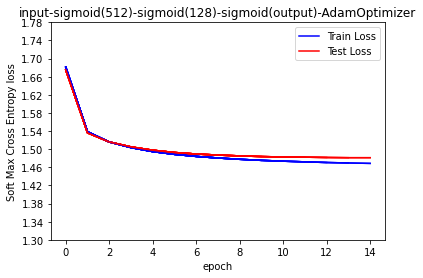

In [10]:
# Since we are using sigmoid activations in hiden layers we will be using weights that are initalized as weights_sgd
y_sgd = multilayer_perceptron(x, weights_sgd, biases)

# https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits
cost_sgd = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = y_sgd, labels = y_))

# https://github.com/amitmac/Question-Answering/issues/2
# there are many optimizers available: https://www.tensorflow.org/versions/r1.2/api_guides/python/train#Optimizers 
optimizer_adam = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_sgd)
optimizer_sgdc = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost_sgd)

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here c: corresponds to the parameter cost_sgd
            # w : correspondse to the parameter weights_sgd
            # c = sess.run() return the cost after every bath during train
            # w = sess.run() return the weights that are modified after every batch through Back prop
            # w is dict w = {'h1': updated h1 weight vector after the current batch,
            #                'h2': updated h2 weight vector after the current batch, 
            #                'out': updated output weight vector after the current batch, 
            #                }
            # you check these w matrix for every iteration, and check whats happening during back prop
            #
            # note: sess.run() returns parameter values based on the input parameters
            # _, c, w = sess.run([optimizer_adam, cost_sgd,weights_sgd]) it returns three parameters
            # _, c = sess.run([optimizer_adam, cost_sgd ]) it returns two parameters
            # _ = sess.run([optimizer_adam]) it returns one paramter (for the input optimizer it return none)
            # c = sess.run([cost_sgd]) it returns one paramter (for the input cost return error after the batch)

            # feed_dict={x: batch_xs, y_: batch_ys} here x, y_ should be placeholders
            # x, y_ are the input parameters on which the models gets trained

            # here we use AdamOptimizer
            _, c, w = sess.run([optimizer_adam, cost_sgd,weights_sgd], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_sgd, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax, np.arange(1.3, 1.8, step=0.04), "input-sigmoid(512)-sigmoid(128)-sigmoid(output)-AdamOptimizer")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))
    plt_dynamic(xs, ytrs, ytes, ax, np.arange(1.3, 1.8, step=0.04), "input-sigmoid(512)-sigmoid(128)-sigmoid(output)-AdamOptimizer")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(y_sgd,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))

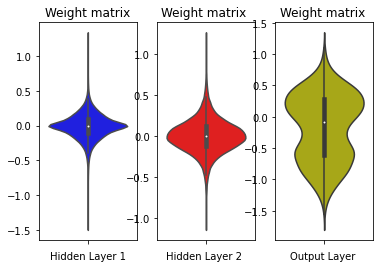

In [11]:
# Plot weight distriubtion at the end of training.

import seaborn as sns
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 3, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 3, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 3, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

__ Model 1 + GradientDescentOptimizer __

Epoch: 0001 train cost=2.324078248 test cost=2.323565255
Epoch: 0002 train cost=2.318853168 test cost=2.318408380
Epoch: 0003 train cost=2.314368713 test cost=2.313925470
Epoch: 0004 train cost=2.310707954 test cost=2.310278742
Epoch: 0005 train cost=2.307844072 test cost=2.307464117
Epoch: 0006 train cost=2.305664919 test cost=2.305263262
Epoch: 0007 train cost=2.304023066 test cost=2.303600789
Epoch: 0008 train cost=2.302771764 test cost=2.302343805
Epoch: 0009 train cost=2.301794330 test cost=2.301366895
Epoch: 0010 train cost=2.301004118 test cost=2.300603811
Epoch: 0011 train cost=2.300345949 test cost=2.299929579
Epoch: 0012 train cost=2.299783036 test cost=2.299375303
Epoch: 0013 train cost=2.299287732 test cost=2.298861061
Epoch: 0014 train cost=2.298842326 test cost=2.298425954
Epoch: 0015 train cost=2.298432234 test cost=2.298015189
Accuracy: 0.1135


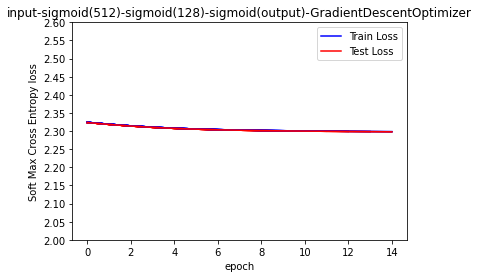

In [12]:
# We can now launch the model in an InteractiveSession

# We first have to create an operation to initialize the variables we created:
# https://github.com/amitmac/Question-Answering/issues/2

# Note: make sure you initialize variables.

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here we use GradientDescentOptimizer
            _, c, w = sess.run([optimizer_sgdc, cost_sgd, weights_sgd], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_sgd, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax, np.arange(2, 2.6, step=0.05), "input-sigmoid(512)-sigmoid(128)-sigmoid(output)-GradientDescentOptimizer")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))
    plt_dynamic(xs, ytrs, ytes, ax, np.arange(2, 2.6, step=0.05), "input-sigmoid(512)-sigmoid(128)-sigmoid(output)-GradientDescentOptimizer")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(y_sgd,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))

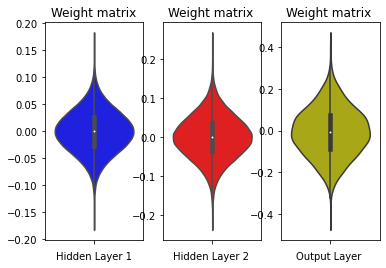

In [13]:
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 3, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 3, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 3, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

<h3> Model 2: input (784) - ReLu(512) - ReLu(128) - sigmoid(output 10) </h3>

In [14]:
# https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/multi_layer_perceptron_mnist.html
# Create model
def multilayer_perceptron_relu(x, weights, biases):
    # Use tf.matmul instead of "*" because tf.matmul can change it's dimensions on the fly (broadcast)
    print( 'x:', x.get_shape(), 'W[h1]:', weights['h1'].get_shape(), 'b[h1]:', biases['b1'].get_shape())        
    
    # Hidden layer with ReLu activation
    # https://en.wikipedia.org/wiki/Rectifier_(neural_networks)
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1']) #(x*weights['h1']) + biases['b1']
    layer_1 = tf.nn.relu(layer_1)
    print( 'layer_1:', layer_1.get_shape(), 'W[h2]:', weights['h2'].get_shape(), 'b[h2]:', biases['b2'].get_shape())        
    
    # Hidden layer with ReLu activation
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2']) # (layer_1 * weights['h2']) + biases['b2'] 
    layer_2 = tf.nn.relu(layer_2)
    print( 'layer_2:', layer_2.get_shape(), 'W[out]:', weights['out'].get_shape(), 'b3:', biases['out'].get_shape())        
    
    # Output layer with Sigmoid activation
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out'] # (layer_2 * weights['out']) + biases['out']    
    out_layer = tf.nn.sigmoid(out_layer)
    print('out_layer:',out_layer.get_shape())

    return out_layer

__ Input-ReLu(512)-ReLu(128)-sigmoid(output) - AdamOptimizer  __

x: (?, 784) W[h1]: (784, 512) b[h1]: (512,)
layer_1: (?, 512) W[h2]: (512, 128) b[h2]: (128,)
layer_2: (?, 128) W[out]: (128, 10) b3: (10,)
out_layer: (?, 10)
Epoch: 0001 train cost=1.555981197 test cost=1.550556289
Epoch: 0002 train cost=1.498694980 test cost=1.498734222
Epoch: 0003 train cost=1.487134310 test cost=1.490677338
Epoch: 0004 train cost=1.481457447 test cost=1.487140043
Epoch: 0005 train cost=1.477766005 test cost=1.484622313
Epoch: 0006 train cost=1.474793326 test cost=1.482695038
Epoch: 0007 train cost=1.472857750 test cost=1.482474368
Epoch: 0008 train cost=1.471297036 test cost=1.481315843
Epoch: 0009 train cost=1.470332201 test cost=1.480650216
Epoch: 0010 train cost=1.469167696 test cost=1.480490485
Epoch: 0011 train cost=1.468836524 test cost=1.480413387
Epoch: 0012 train cost=1.468069963 test cost=1.479643523
Epoch: 0013 train cost=1.467237177 test cost=1.480041139
Epoch: 0014 train cost=1.467333083 test cost=1.480165198
Epoch: 0015 train cost=1.467024850 test cos

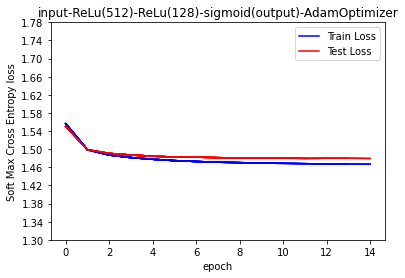

In [15]:
# Since we are using Relu activations in hiden layers we will be using weights that are initalized as weights_relu
yrelu = multilayer_perceptron_relu(x, weights_relu, biases)

# https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits
cost_relu = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = yrelu, labels = y_))
# https://github.com/amitmac/Question-Answering/issues/2
# there are many optimizers available: https://www.tensorflow.org/versions/r1.2/api_guides/python/train#Optimizers 
optimizer_relu_adam = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_relu)
optimizer_relu_sgdc = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost_relu)
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here we use AdamOptimizer
            _, c, w = sess.run([optimizer_relu_adam, cost_relu, weights_relu], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_relu, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax, np.arange(1.3, 1.8, step=0.04), "input-ReLu(512)-ReLu(128)-sigmoid(output)-AdamOptimizer")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax,np.arange(1.3, 1.8, step=0.04), "input-ReLu(512)-ReLu(128)-sigmoid(output)-AdamOptimizer")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(yrelu,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))

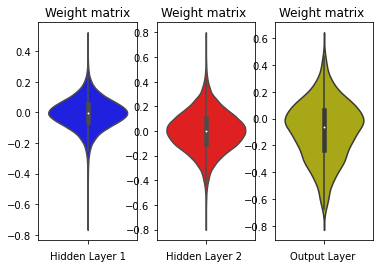

In [16]:
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 3, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 3, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 3, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

__Input-ReLu(512)-ReLu(128)-sigmoid(output) - GradientDescentOptimizer__

Epoch: 0001 train cost=2.312975441 test cost=2.307917352
Epoch: 0002 train cost=2.195871444 test cost=2.189866710
Epoch: 0003 train cost=2.111976282 test cost=2.105031752
Epoch: 0004 train cost=2.048336797 test cost=2.040806294
Epoch: 0005 train cost=1.983800109 test cost=1.976739709
Epoch: 0006 train cost=1.932066135 test cost=1.925463796
Epoch: 0007 train cost=1.897557574 test cost=1.890979860
Epoch: 0008 train cost=1.871573553 test cost=1.864943983
Epoch: 0009 train cost=1.851099093 test cost=1.844481593
Epoch: 0010 train cost=1.834404501 test cost=1.827724960
Epoch: 0011 train cost=1.820467482 test cost=1.813765195
Epoch: 0012 train cost=1.808580715 test cost=1.801846617
Epoch: 0013 train cost=1.798306756 test cost=1.791541263
Epoch: 0014 train cost=1.789316650 test cost=1.782545719
Epoch: 0015 train cost=1.781351391 test cost=1.774533921
Accuracy: 0.7717


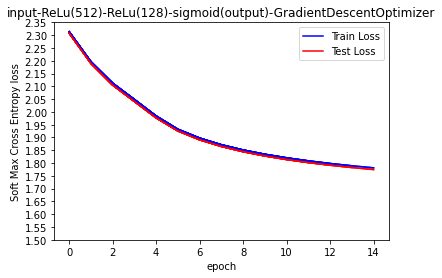

In [17]:
# We can now launch the model in an InteractiveSession

# We first have to create an operation to initialize the variables we created:
# https://github.com/amitmac/Question-Answering/issues/2

# Note: make sure you initialize variables after AdamOptimizer

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here we use GradientDescentOptimizer
            _, c, w = sess.run([optimizer_relu_sgdc, cost_relu, weights_relu], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_relu, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax, np.arange(1.5, 2.4, step=0.05), "input-ReLu(512)-ReLu(128)-sigmoid(output)-GradientDescentOptimizer")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax, np.arange(1.5, 2.4, step=0.05), "input-ReLu(512)-ReLu(128)-sigmoid(output)-GradientDescentOptimizer")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(yrelu,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))

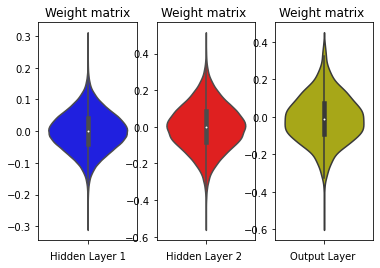

In [18]:
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 3, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 3, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 3, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

<h3> Model 3: Input - Sigmoid(BatchNormalization(512)) - Sigmoid(BatchNormalization(128))- Sigmoid(output) </h3>

In [19]:
# https://www.tensorflow.org/api_docs/python/tf/nn/batch_normalization
# https://r2rt.com/implementing-batch-normalization-in-tensorflow.html
epsilon = 1e-3
def multilayer_perceptron_batch(x, weights, biases):
    # Use tf.matmul instead of "*" because tf.matmul can change it's dimensions on the fly (broadcast)
    print( 'x:', x.get_shape(), 'W[h1]:', weights['h1'].get_shape(), 'b[h1]:', biases['b1'].get_shape())        
    
    ############################################################
    # Hidden layer with Sigmoid activation and batch normalization
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1']) #(x*weights['h1']) + biases['b1']
    
    # https://www.tensorflow.org/api_docs/python/tf/nn/moments
    # Calculate the mean and variance of x.
    batch_mean_1, batch_var_1 = tf.nn.moments(layer_1,[0])
    
    scale_1 = tf.Variable(tf.ones([n_hidden_1]))
    beta_1 = tf.Variable(tf.zeros([n_hidden_1]))
    
    # https://www.tensorflow.org/api_docs/python/tf/nn/batch_normalization
    layer_1 = tf.nn.batch_normalization(layer_1, batch_mean_1, batch_var_1, beta_1, scale_1, epsilon)
    layer_1 = tf.nn.sigmoid(layer_1)
    
    print( 'layer_1:', layer_1.get_shape(), 'W[h2]:', weights['h2'].get_shape(), 'b[h2]:', biases['b2'].get_shape())        
    
    #####################################################################################
    
    # Hidden layer with Sigmoid activation and batch normalization
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2']) # (layer_1 * weights['h2']) + biases['b2'] 
    
    # https://www.tensorflow.org/api_docs/python/tf/nn/moments
    # Calculate the mean and variance of x.
    batch_mean_2, batch_var_2 = tf.nn.moments(layer_2, [0])
    
    scale_2 = tf.Variable(tf.ones([n_hidden_2]))
    beta_2 = tf.Variable(tf.zeros([n_hidden_2]))
    
    layer_2 = tf.nn.batch_normalization(layer_2, batch_mean_2, batch_var_2, beta_2, scale_2, epsilon)
    layer_2 = tf.nn.sigmoid(layer_2)
    print( 'layer_2:', layer_2.get_shape(), 'W[out]:', weights['out'].get_shape(), 'b3:', biases['out'].get_shape())        
    
    ######################################################################################
    
    # output layer with Sigmoid activation 
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out'] # (layer_2 * weights['out']) + biases['out']    
    out_layer = tf.nn.sigmoid(out_layer)
    print('out_layer:',out_layer.get_shape())

    return out_layer

__ Model 3+ AdamOptimizer  __

x: (?, 784) W[h1]: (784, 512) b[h1]: (512,)
layer_1: (?, 512) W[h2]: (512, 128) b[h2]: (128,)
layer_2: (?, 128) W[out]: (128, 10) b3: (10,)
out_layer: (?, 10)
Epoch: 0001 train cost=1.699760322 test cost=1.691304763
Epoch: 0002 train cost=1.555930131 test cost=1.552141806
Epoch: 0003 train cost=1.516587105 test cost=1.515956685
Epoch: 0004 train cost=1.500447753 test cost=1.501715111
Epoch: 0005 train cost=1.491423154 test cost=1.494711868
Epoch: 0006 train cost=1.485108348 test cost=1.489895583
Epoch: 0007 train cost=1.481902964 test cost=1.487579127
Epoch: 0008 train cost=1.479254690 test cost=1.485928856
Epoch: 0009 train cost=1.477168184 test cost=1.484950804
Epoch: 0010 train cost=1.475083461 test cost=1.483318342
Epoch: 0011 train cost=1.473612227 test cost=1.482206454
Epoch: 0012 train cost=1.472622285 test cost=1.481910461
Epoch: 0013 train cost=1.471654535 test cost=1.481966744
Epoch: 0014 train cost=1.470542086 test cost=1.481607058
Epoch: 0015 train cost=1.470072915 test cos

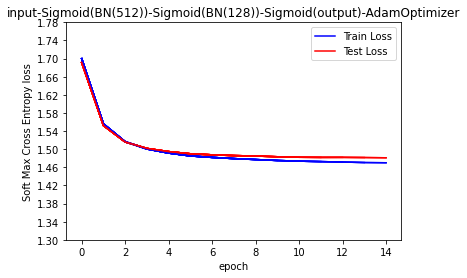

In [20]:
# Since we are using sigmoid activations in hiden layers we will be using weights that are initalized as weights_sgd
ybatch = multilayer_perceptron_batch(x, weights_sgd, biases)

# https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits
cost_batch = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = ybatch, labels = y_))
# https://github.com/amitmac/Question-Answering/issues/2
# there are many optimizers available: https://www.tensorflow.org/versions/r1.2/api_guides/python/train#Optimizers 
optimizer_batch_adam = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_batch)
optimizer_batch_sgdc = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost_batch)
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here we use AdamOptimizer
            _, c, w = sess.run([optimizer_batch_adam, cost_batch, weights_sgd], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_batch, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax, np.arange(1.3, 1.8, step=0.04), "input-Sigmoid(BN(512))-Sigmoid(BN(128))-Sigmoid(output)-AdamOptimizer")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax, np.arange(1.3, 1.8, step=0.04), "input-Sigmoid(BN(512))-Sigmoid(BN(128))-Sigmoid(output)-AdamOptimizer")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(ybatch,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))

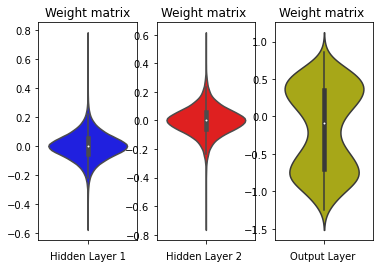

In [21]:
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 3, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 3, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 3, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

__ Model 3 + GradientDescentOptimizer  __

Epoch: 0001 train cost=2.281473876 test cost=2.281283868
Epoch: 0002 train cost=2.233012240 test cost=2.231288040
Epoch: 0003 train cost=2.191933498 test cost=2.189018023
Epoch: 0004 train cost=2.156905368 test cost=2.153016718
Epoch: 0005 train cost=2.127079317 test cost=2.122449713
Epoch: 0006 train cost=2.101640364 test cost=2.096435620
Epoch: 0007 train cost=2.080010783 test cost=2.074346705
Epoch: 0008 train cost=2.061629885 test cost=2.055369939
Epoch: 0009 train cost=2.045298237 test cost=2.038941084
Epoch: 0010 train cost=2.031192048 test cost=2.024538787
Epoch: 0011 train cost=2.018530650 test cost=2.011685209
Epoch: 0012 train cost=2.006963810 test cost=2.000148801
Epoch: 0013 train cost=1.996653369 test cost=1.989683371
Epoch: 0014 train cost=1.987131131 test cost=1.980104548
Epoch: 0015 train cost=1.978402385 test cost=1.971267942
Accuracy: 0.8013


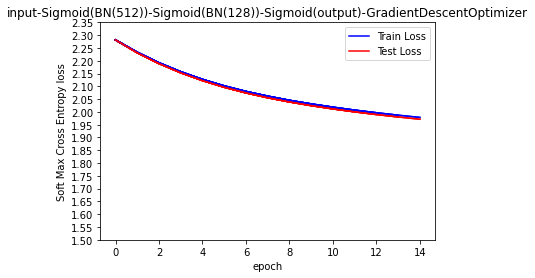

In [22]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here we use GradientDescentOptimizer
            _, c, w = sess.run([optimizer_batch_sgdc, cost_batch, weights_sgd], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_batch, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax,np.arange(1.5, 2.4, step=0.05), "input-Sigmoid(BN(512))-Sigmoid(BN(128))-Sigmoid(output)-GradientDescentOptimizer")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax, np.arange(1.5, 2.4, step=0.05), "input-Sigmoid(BN(512))-Sigmoid(BN(128))-Sigmoid(output)-GradientDescentOptimizer")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(ybatch,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))

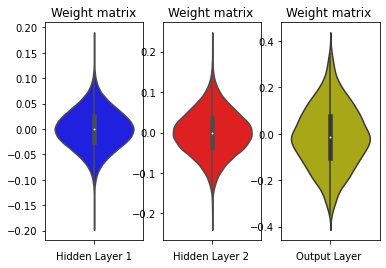

In [23]:
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 3, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 3, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 3, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

<h3> Model 4: Input - ReLu(512) - Dropout - ReLu(128)- Dropout -Sigmoid(output) </h3>

In [24]:
# https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/multi_layer_perceptron_mnist.html
# Create model
def multilayer_perceptron_dropout(x, weights, biases):
    # Use tf.matmul instead of "*" because tf.matmul can change it's dimensions on the fly (broadcast)
    print( 'x:', x.get_shape(), 'W[h1]:', weights['h1'].get_shape(), 'b[h1]:', biases['b1'].get_shape())        
    # we are adding a drop out layer after input layers with parameter keep_prob_input
    
    # Hidden layer with ReLu activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1']) #(x*weights['h1']) + biases['b1']
    layer_1 = tf.nn.relu(layer_1)
    # we are adding a drop out layer after the first hidden layer with parameter keep_prob
    layer_1_drop = tf.nn.dropout(layer_1, keep_prob)
    
    print( 'layer_1:', layer_1.get_shape(), 'W[h2]:', weights['h2'].get_shape(), 'b[h2]:', biases['b2'].get_shape())        
    
    # Hidden layer with ReLu activation
    layer_2 = tf.add(tf.matmul(layer_1_drop, weights['h2']), biases['b2']) # (layer_1 * weights['h2']) + biases['b2'] 
    layer_2 = tf.nn.relu(layer_2)
    # we are adding a drop out layer after the first hidden layer with parameter keep_prob
    layer_2_drop = tf.nn.dropout(layer_2, keep_prob)
    print( 'layer_2:', layer_2.get_shape(), 'W[out]:', weights['out'].get_shape(), 'b3:', biases['out'].get_shape())        
    
    # Output layer with Sigmoid activation
    out_layer = tf.matmul(layer_2_drop, weights['out']) + biases['out'] # (layer_2 * weights['out']) + biases['out']    
    out_layer = tf.nn.sigmoid(out_layer)
    print('out_layer:',out_layer.get_shape())

    return out_layer

__ Model 4 + AdamOptimizer __

x: (?, 784) W[h1]: (784, 512) b[h1]: (512,)
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
layer_1: (?, 512) W[h2]: (512, 128) b[h2]: (128,)
layer_2: (?, 128) W[out]: (128, 10) b3: (10,)
out_layer: (?, 10)
Epoch: 0001 train cost=1.682207094 test cost=1.610211818
Epoch: 0002 train cost=1.549991286 test cost=1.515881254
Epoch: 0003 train cost=1.527002310 test cost=1.503076093
Epoch: 0004 train cost=1.515260745 test cost=1.496646339
Epoch: 0005 train cost=1.507879644 test cost=1.492628929
Epoch: 0006 train cost=1.503201845 test cost=1.489692930
Epoch: 0007 train cost=1.500393632 test cost=1.487502983
Epoch: 0008 train cost=1.496761252 test cost=1.486005604
Epoch: 0009 train cost=1.495251111 test cost=1.484930501
Epoch: 0010 train cost=1.491596309 test cost=1.483192320
Epoch: 0011 train cost=1.490092670 test cost=1.482902210
Epoch: 0012 train cost=1.490118778 test cost=1.482519541
Epoch: 0013 train cost=1.487980400 test co

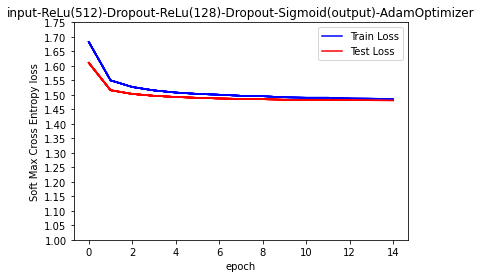

In [25]:
# Since we are using Relu activations in hiden layers we will be using weights that are initalized as weights_relu
ydrop = multilayer_perceptron_dropout(x, weights_relu, biases)

# https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits
cost_drop = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = ydrop, labels = y_))
# https://github.com/amitmac/Question-Answering/issues/2
# there are many optimizers available: https://www.tensorflow.org/versions/r1.2/api_guides/python/train#Optimizers 
optimizer_drop_adam = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_drop)
optimizer_drop_sgdc = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost_drop)

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            
            # here we use AdamOptimizer
            _, c, w = sess.run([optimizer_drop_adam, cost_drop, weights_relu], feed_dict={x: batch_xs, y_: batch_ys, keep_prob: 0.5})
            train_avg_cost += c / total_batch
            c = sess.run(cost_drop, feed_dict={x: mnist.test.images, y_: mnist.test.labels,  keep_prob: 1.0})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax,np.arange(1, 1.8, step=0.05), "input-ReLu(512)-Dropout-ReLu(128)-Dropout-Sigmoid(output)-AdamOptimizer")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax,np.arange(1, 1.8, step=0.05), "input-ReLu(512)-Dropout-ReLu(128)-Dropout-Sigmoid(output)-AdamOptimizer")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(ydrop,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0 }))

Text(0.5, 0, 'Output Layer ')

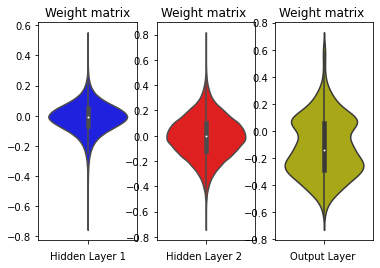

In [26]:
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 3, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 3, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 3, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
# plt.show()

Epoch: 0001 train cost=2.341080256 test cost=2.278438925
Epoch: 0002 train cost=2.321318716 test cost=2.237151155
Epoch: 0003 train cost=2.305263660 test cost=2.198001709
Epoch: 0004 train cost=2.287545788 test cost=2.161495952
Epoch: 0005 train cost=2.271334467 test cost=2.127690358
Epoch: 0006 train cost=2.256067008 test cost=2.094571955
Epoch: 0007 train cost=2.238429116 test cost=2.063584289
Epoch: 0008 train cost=2.219938438 test cost=2.030661347
Epoch: 0009 train cost=2.205609084 test cost=2.001226219
Epoch: 0010 train cost=2.186057899 test cost=1.972803186
Epoch: 0011 train cost=2.168662488 test cost=1.945786452
Epoch: 0012 train cost=2.153199462 test cost=1.920872025
Epoch: 0013 train cost=2.136374158 test cost=1.899601464
Epoch: 0014 train cost=2.119721756 test cost=1.880792893
Epoch: 0015 train cost=2.103520582 test cost=1.864751861
Accuracy: 0.6999


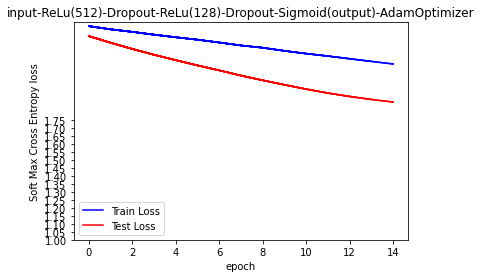

In [27]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            
            # here we use AdamOptimizer
            _, c, w = sess.run([optimizer_drop_sgdc, cost_drop, weights_relu], feed_dict={x: batch_xs, y_: batch_ys, keep_prob: 0.5})
            train_avg_cost += c / total_batch
            c = sess.run(cost_drop, feed_dict={x: mnist.test.images, y_: mnist.test.labels,  keep_prob: 1.0})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax,np.arange(1, 1.8, step=0.05), "input-ReLu(512)-Dropout-ReLu(128)-Dropout-Sigmoid(output)-AdamOptimizer")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax,np.arange(1, 1.8, step=0.05), "input-ReLu(512)-Dropout-ReLu(128)-Dropout-Sigmoid(output)-AdamOptimizer")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(ydrop,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0 }))

Text(0.5, 0, 'Output Layer ')

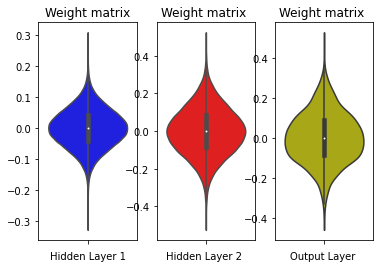

In [28]:
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 3, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 3, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 3, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
# plt.show()